In [1]:
!pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [20]:
%load_ext autoreload
import re, time, os, shutil, json
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
from monai.data import list_data_collate
import tempfile
import monai
from monai.data import DataLoader, Dataset 
from monai.transforms.intensity.array import ScaleIntensity
from monai.transforms import (
    LoadImage, EnsureChannelFirst, Spacing,
    RandFlip, Resize, EnsureType,
    LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose, ScaleIntensityd, 
    AddChanneld, MapTransform, AsChannelFirstd, EnsureType, 
    Activations, AsDiscrete, RandCropByPosNegLabeld, 
    RandRotate90d, LabelToMaskd, RandFlipd, RandRotated, Spacingd, RandAffined
)

from dataset import setup_dataloaders, setup_datafiles

import configdot
import torch
from monai.config import print_config
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!mkdir -p ./MONAI_TMP

In [3]:
os.environ['MONAI_DATA_DIRECTORY'] = "./MONAI_TMP"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./MONAI_TMP


# Create dataset

In [4]:
config = configdot.parse_config('configs/config.ini')

In [6]:
print(torch.cuda.is_available())
DEVICE = config.opt.device if hasattr(config.opt, "device") else 1
device = torch.device(DEVICE)
torch.cuda.set_device(DEVICE)

print('Setting GPU#:', DEVICE)
print('Using GPU#:', torch.cuda.current_device())

True
Setting GPU#: 3
Using GPU#: 3


### Loading train-test split


In [7]:
import numpy as np
subjects_list = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()

In [8]:
subjects_list

{'train': array(['n16', 'n49', 'n71', 'n44', 'n80', 'G133', 'n21', 'n67', 'n12',
        'n81', 'n47', 'n61', 'n62', 'n75', 'G180', 'n10', 'n60', 'G258',
        'n64', 'n31', 'n36', 'n11', 'n55', 'G371', 'n26', 'n68', 'n51',
        'G324', 'n17', 'n66', 'n59', 'n15', 'n58', 'n69', 'n33', 'n41',
        'n14', 'n65', 'n52', 'n73', 'G368', 'G081', 'G294', 'G409', 'n27',
        'n40', 'n30', 'n7', 'n70', 'n29', 'n13', 'n74', 'G507', 'n83',
        'n45', 'n78', 'n39', 'n8', 'n22', 'n54', 'n87', 'G256', 'G414',
        'n24', 'n56', 'n28', 'n57', 'n2', 'n23', 'G184', 'n18', 'n53',
        'n38', 'n19', 'n35', 'n3', 'n5', 'n84', 'n79', 'n50', 'n9', 'n25',
        'G044', 'n20', 'n82', 'n48', 'G417'], dtype=object),
 'test': array(['n43', 'n72', 'n46', 'n32', 'G061', 'n37', 'n88', 'G150', 'n76',
        'n77'], dtype=object)}

In [29]:
train_list = subjects_list.get('train')
val_list = subjects_list.get('test')

feat_params = config.dataset.features

print(len(train_list), len(val_list))

87 10


In [30]:
feat_params

['image',
 't2',
 'flair',
 'blurring-t1',
 'blurring-Flair',
 'cr-t2',
 'cr-Flair',
 'thickness',
 'curv',
 'sulc',
 'variance']

In [22]:
train_loader, val_loader = setup_dataloaders(config)
train_files, val_files = setup_datafiles(subjects_list, config)

Train set length: 87
Test set length: 10
Train set length: 87
Test set length: 10


### Transformation and Augmentation

In [31]:
assert config.default.interpolate
spatial_size_conf = tuple(config.default.interpolation_size)

if config.opt.augmentation:
    rot_range = config.opt.rotation_range

    train_transf = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image", "seg"]),
            RandRotated(keys=["image", "seg"], 
                        range_x=rot_range, 
                        range_y=rot_range, 
                        range_z=rot_range, 
                        prob=0.5),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            Resized(keys=["image", "seg"], spatial_size=spatial_size_conf, mode=('area', 'nearest')),
            Spacingd(keys=['seg'], pixdim=1.0),
            ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
            EnsureTyped(keys=["image", "seg"], dtype=torch.float),
        ]
    )

    val_transf = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image", "seg"]),
            Resized(keys=["image", "seg"], spatial_size=spatial_size_conf, mode=('area', 'nearest')),
            Spacingd(keys=['seg'], pixdim=1.0),
            ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
            EnsureTyped(keys=["image", "seg"], dtype=torch.float),
        ]
    )
    
else:
    raise NotImplementedError

### Visualization

In [32]:
def get_label(path):
    '''
    Extracts label from path, e.g.:
    '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/n16.nii.gz' -> 'n16'
    '''
    return path.split('/')[-1].split('.')[0]

In [33]:
check_batch_size = 10
check_dataset = Dataset(data=train_files, transform=train_transf)
check_loader = DataLoader(check_dataset, 
                          batch_size=check_batch_size, 
                          num_workers=0, 
                          collate_fn=list_data_collate, 
                          pin_memory=torch.cuda.is_available(),
                          shuffle=False
                          )

check_data = monai.utils.misc.first(check_loader)

In [34]:
print(check_data["image"].shape, check_data["seg"].shape, len(feat_params))

torch.Size([10, 11, 128, 128, 128]) torch.Size([10, 1, 128, 128, 128]) 11


In [42]:
feat_params

['image',
 't2',
 'flair',
 'blurring-t1',
 'blurring-Flair',
 'cr-t2',
 'cr-Flair',
 'thickness',
 'curv',
 'sulc',
 'variance']

In [43]:
image.shape

torch.Size([11, 128, 128, 128])

In [68]:
# for k in range(check_batch_size):
    
#     image = check_data['image'][k]
#     seg = check_data['seg'][k]
#     label = get_label(check_dataset.data[k]['seg'])
    
#     print(f"image shape: {image.shape}")
    
#     num_of_channels = len(feat_params)
#     # choose z-coord where there is a label maximum over other axes
#     label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    
#     mask = image[:1,...] <= 0 # `background mask
    
#     torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1

#     fig = plt.figure("image", (10, 5), dpi=200)
#     plt.subplot(1, 1, 1)
#     plt.title(f"{feat_params[i]}")
#     plt.imshow(mask[0,:,:,label_pos])
#     plt.colorbar()
#     plt.xticks([])
#     plt.yticks([])
        
#     fig.suptitle(label, fontsize=20, color='blue')
#     # plt.tight_layout()
#     plt.show()

In [62]:
np.array(feat_params)[torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1]

array(['blurring-Flair', 'thickness', 'curv', 'sulc'], dtype='<U14')

In [70]:
feat_params

['image',
 't2',
 'flair',
 'blurring-t1',
 'blurring-Flair',
 'cr-t2',
 'cr-Flair',
 'thickness',
 'curv',
 'sulc',
 'variance']

In [77]:
image[-3,:,:,label_pos]

tensor([[0.7200, 0.7200, 0.7200,  ..., 0.7200, 0.7200, 0.7200],
        [0.7200, 0.7200, 0.7200,  ..., 0.7200, 0.7200, 0.7200],
        [0.7200, 0.7200, 0.7200,  ..., 0.7200, 0.7200, 0.7200],
        ...,
        [0.7200, 0.7200, 0.7200,  ..., 0.7200, 0.7200, 0.7200],
        [0.7200, 0.7200, 0.7200,  ..., 0.7200, 0.7200, 0.7200],
        [0.7200, 0.7200, 0.7200,  ..., 0.7200, 0.7200, 0.7200]])

image shape: torch.Size([11, 128, 128, 128])


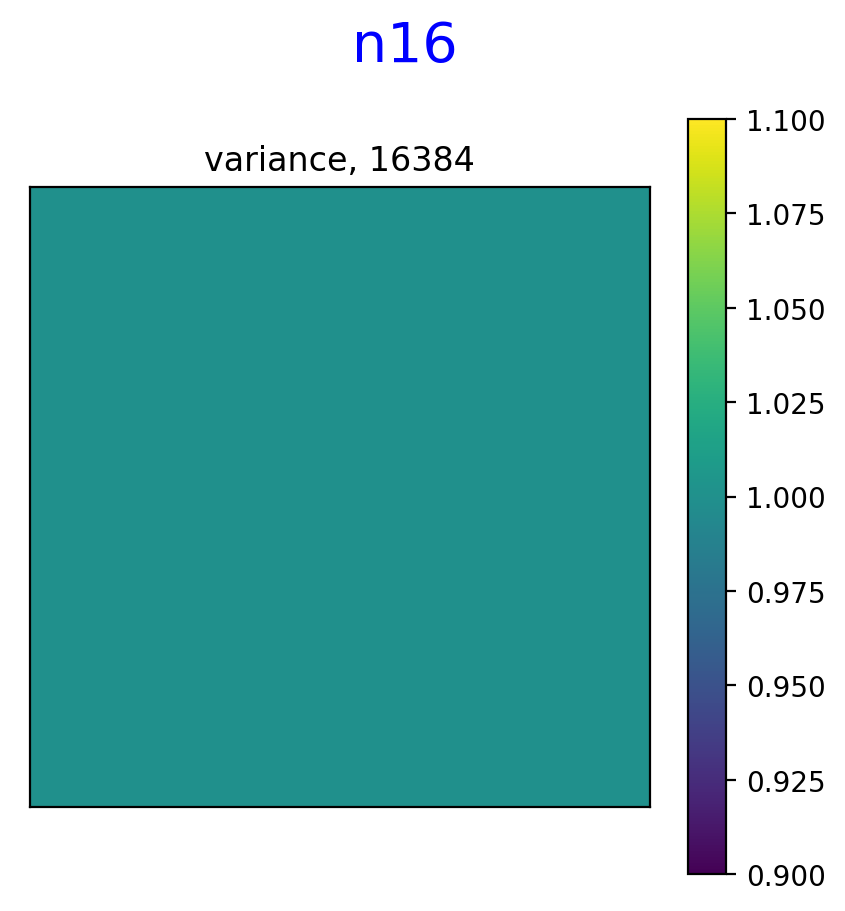

image shape: torch.Size([11, 128, 128, 128])


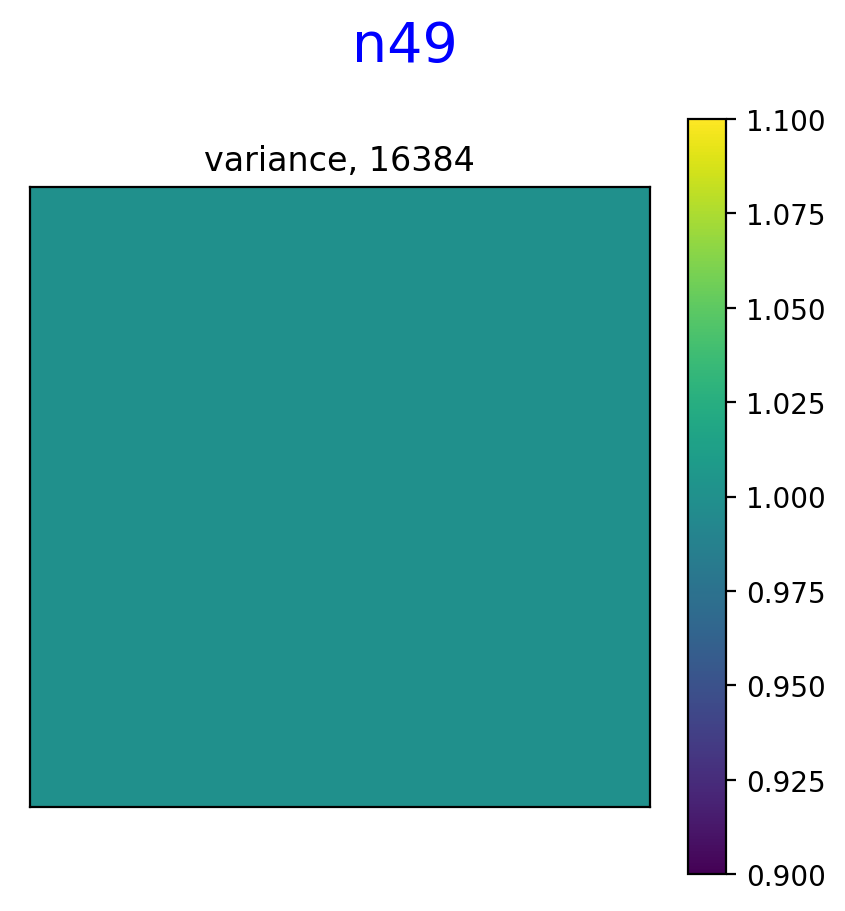

image shape: torch.Size([11, 128, 128, 128])


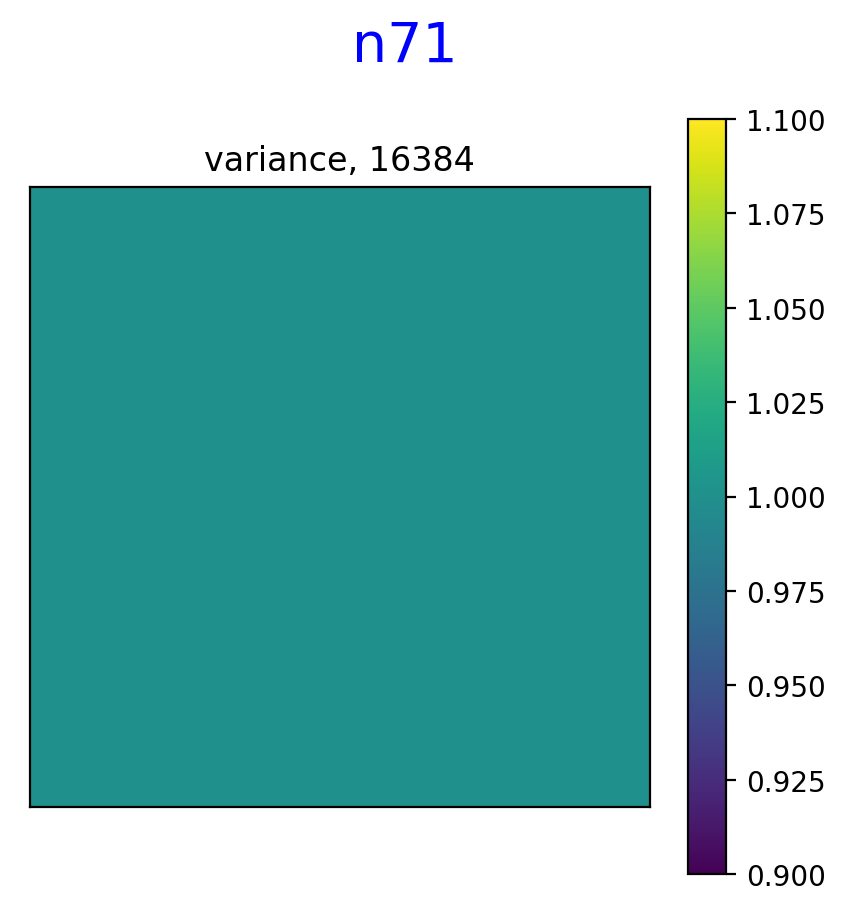

image shape: torch.Size([11, 128, 128, 128])


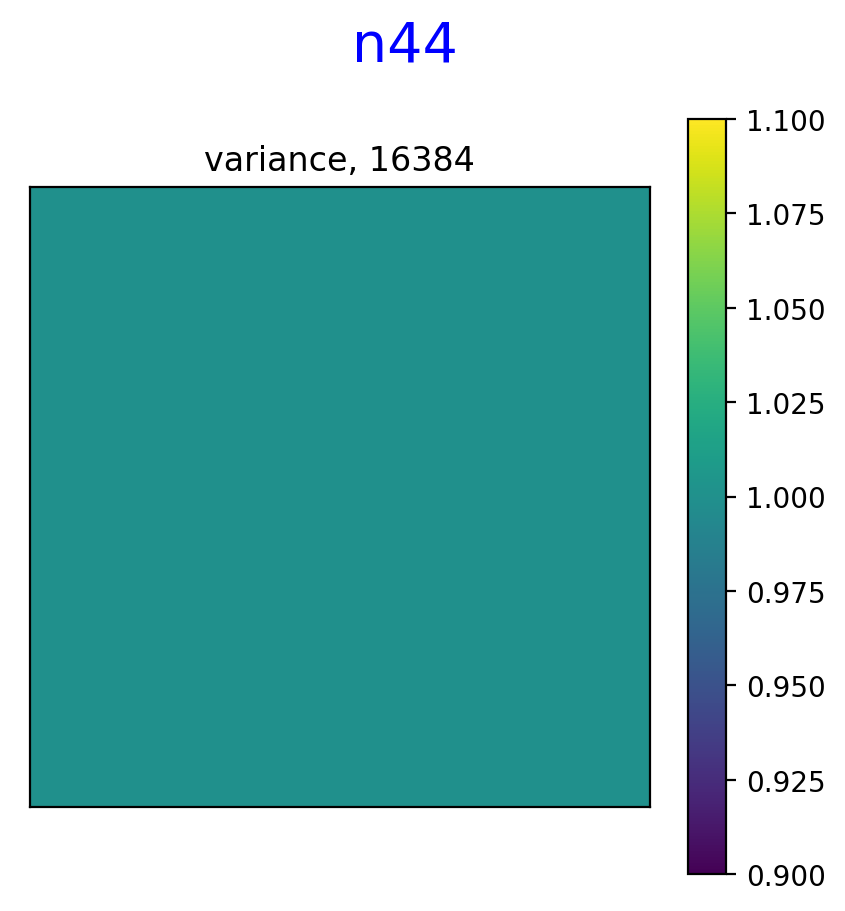

image shape: torch.Size([11, 128, 128, 128])


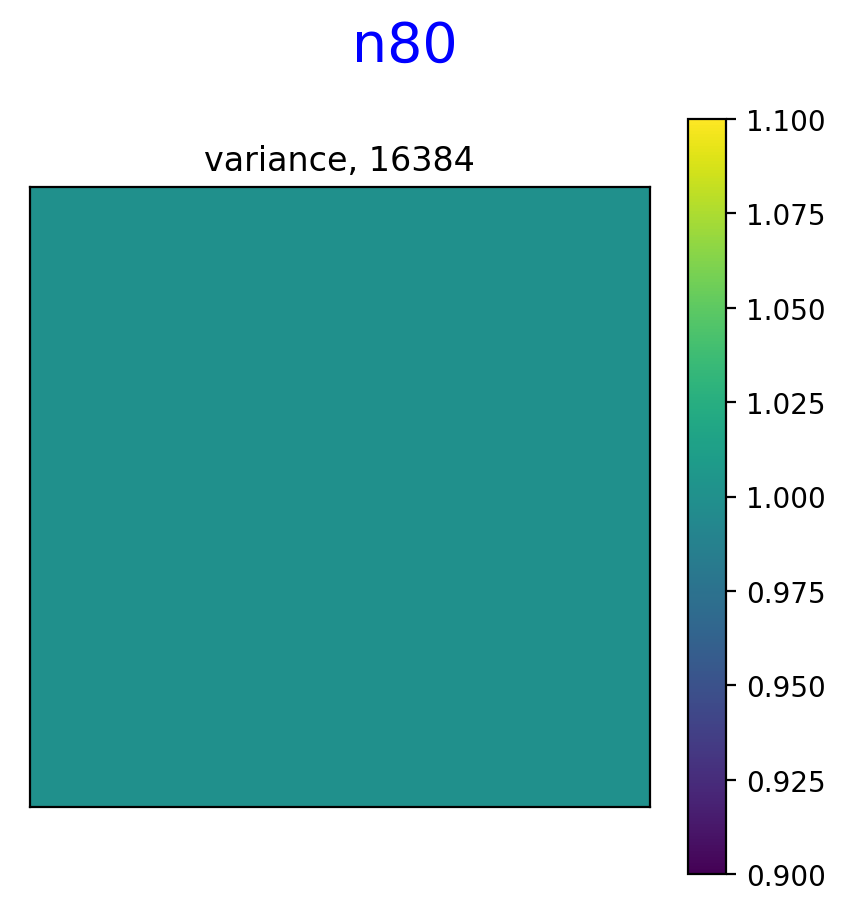

image shape: torch.Size([11, 128, 128, 128])


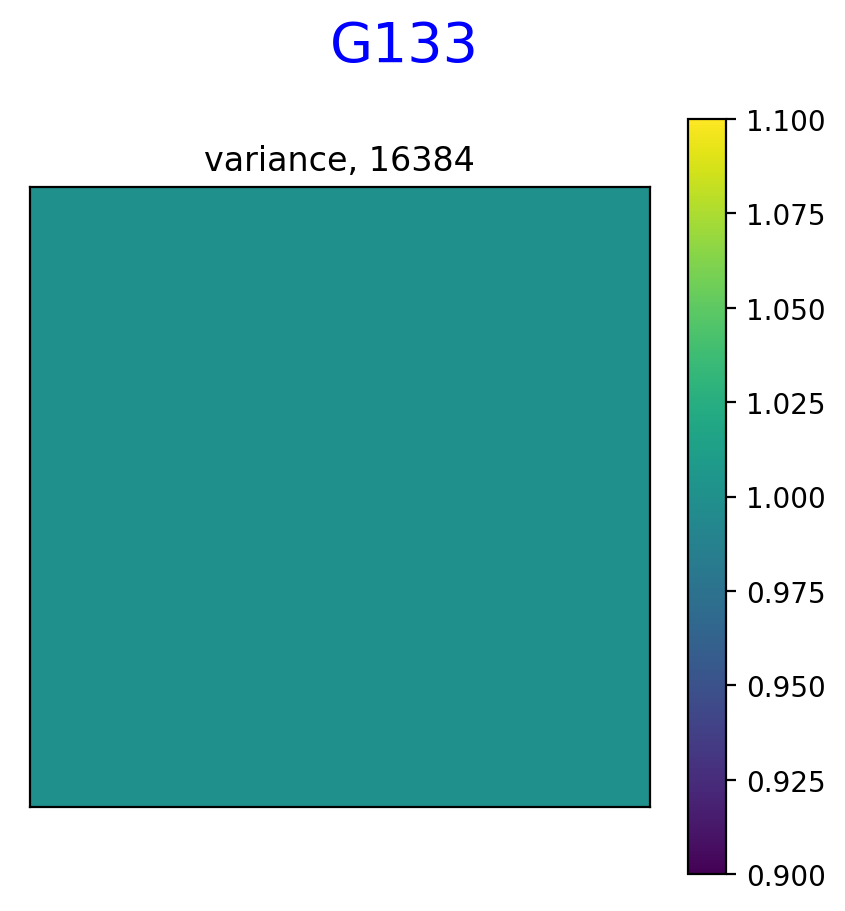

image shape: torch.Size([11, 128, 128, 128])


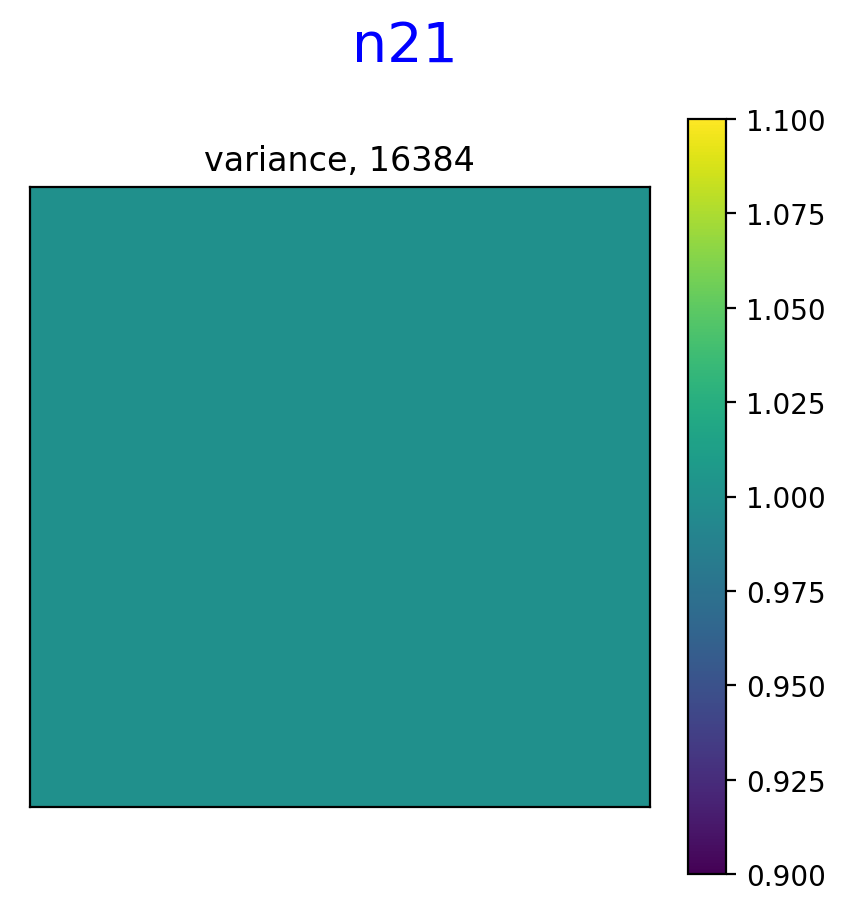

image shape: torch.Size([11, 128, 128, 128])


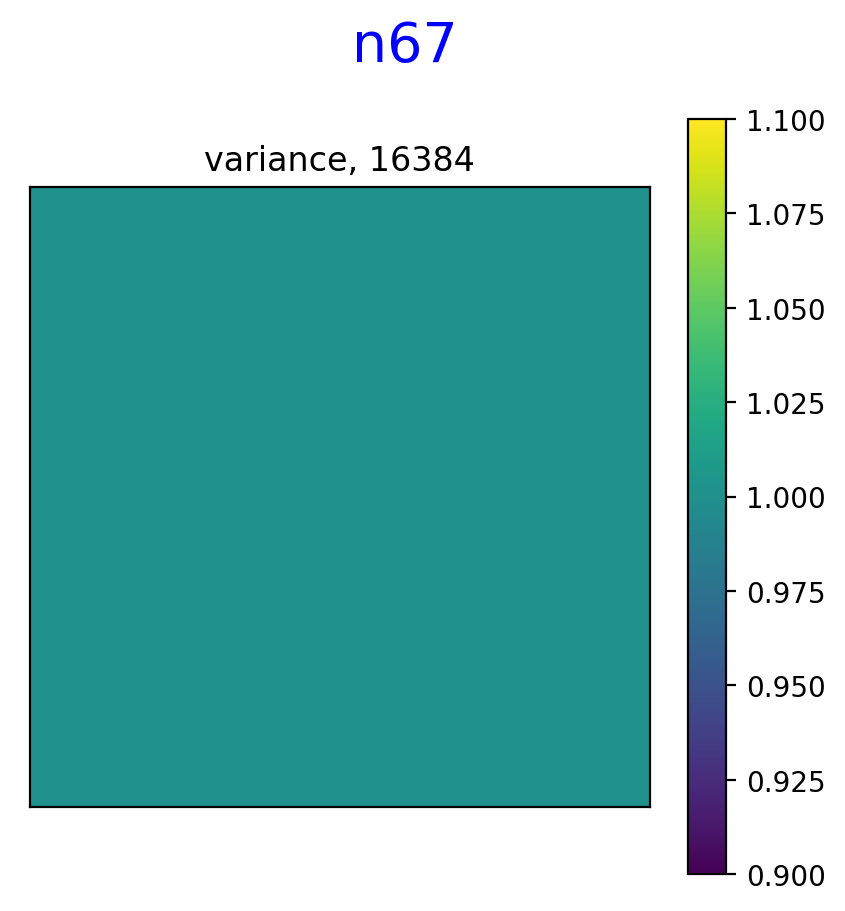

image shape: torch.Size([11, 128, 128, 128])


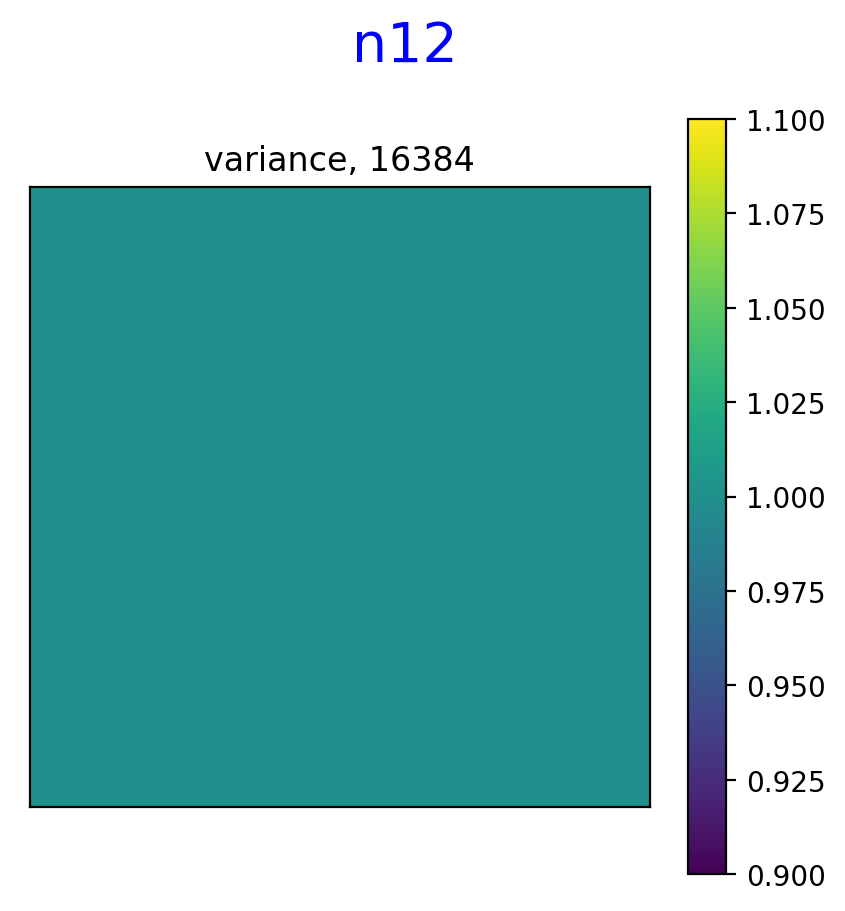

image shape: torch.Size([11, 128, 128, 128])


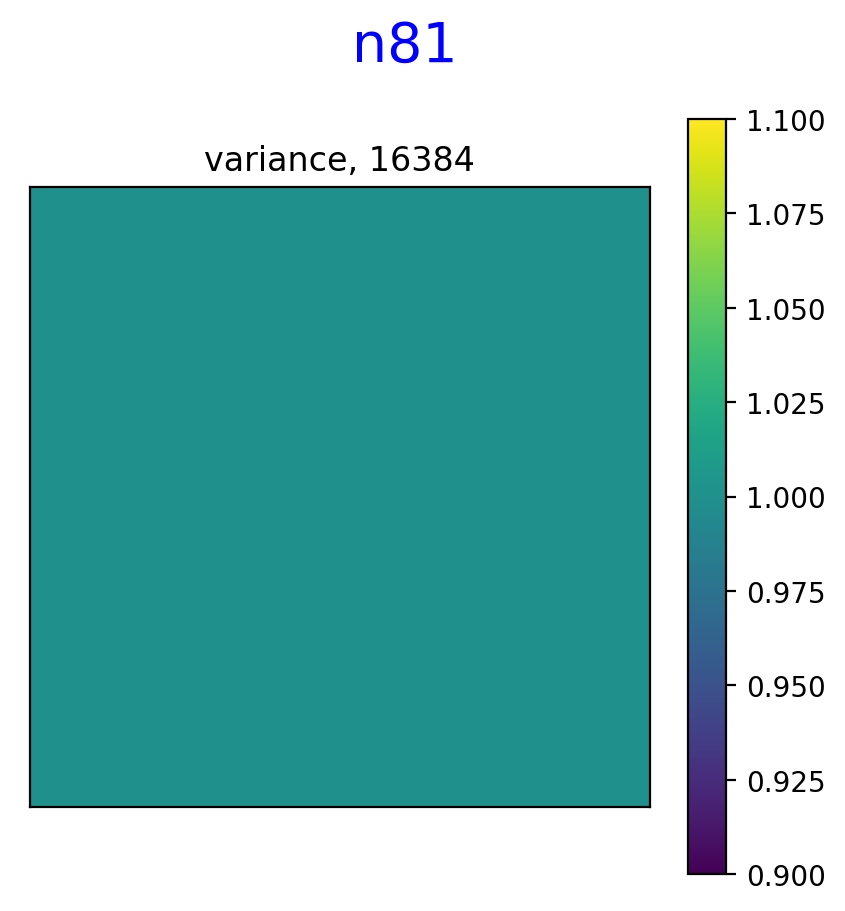

In [79]:
for k in range(check_batch_size):
    
    image = check_data['image'][k]
    seg = check_data['seg'][k]
    label = get_label(check_dataset.data[k]['seg'])
    
    print(f"image shape: {image.shape}")
    
    num_of_channels = len(feat_params)
    # choose z-coord where there is a label maximum over other axes
    label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    
    mask = image[:1,...] <= 0 # `background mask
    torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1

    fig = plt.figure("image", (5, 5), dpi=200)
    
    plt.subplot(1, 1, 1)
    image_bin = image[-2,:,:,label_pos] > 0
    plt.imshow(image_bin)
    plt.colorbar()
    plt.title(f"{feat_params[i]}, {image_bin.sum()}")
    # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
    # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
    plt.xticks([])
    plt.yticks([])
        
    fig.suptitle(label, fontsize=20, color='blue')
    # plt.tight_layout()
    plt.show()

image shape: torch.Size([11, 128, 128, 128])


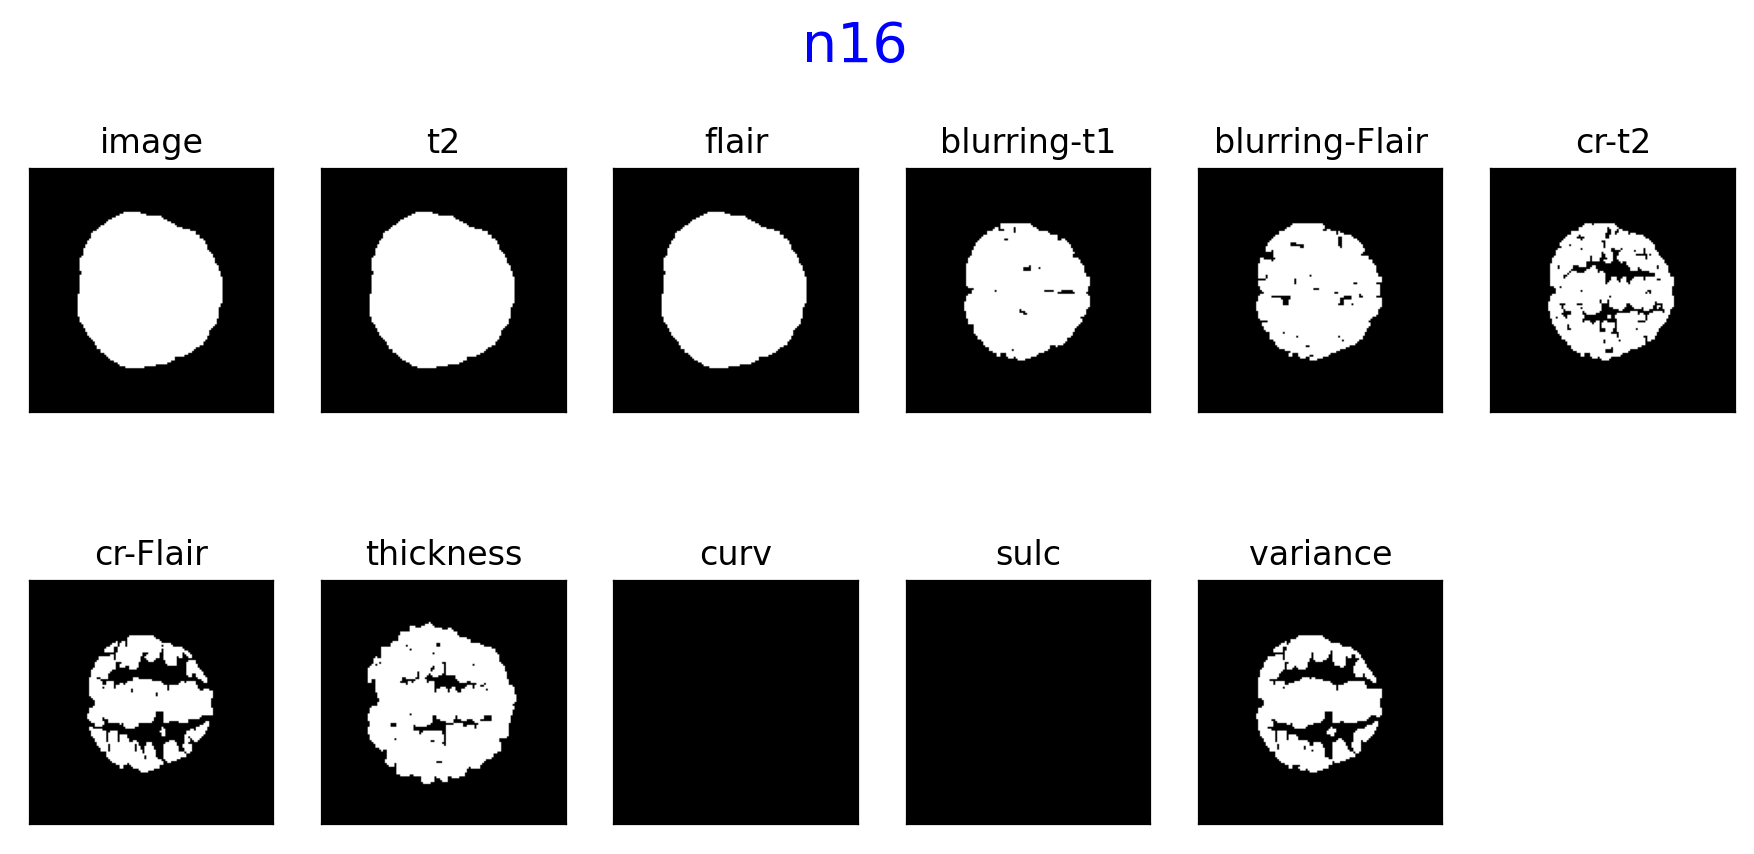

image shape: torch.Size([11, 128, 128, 128])


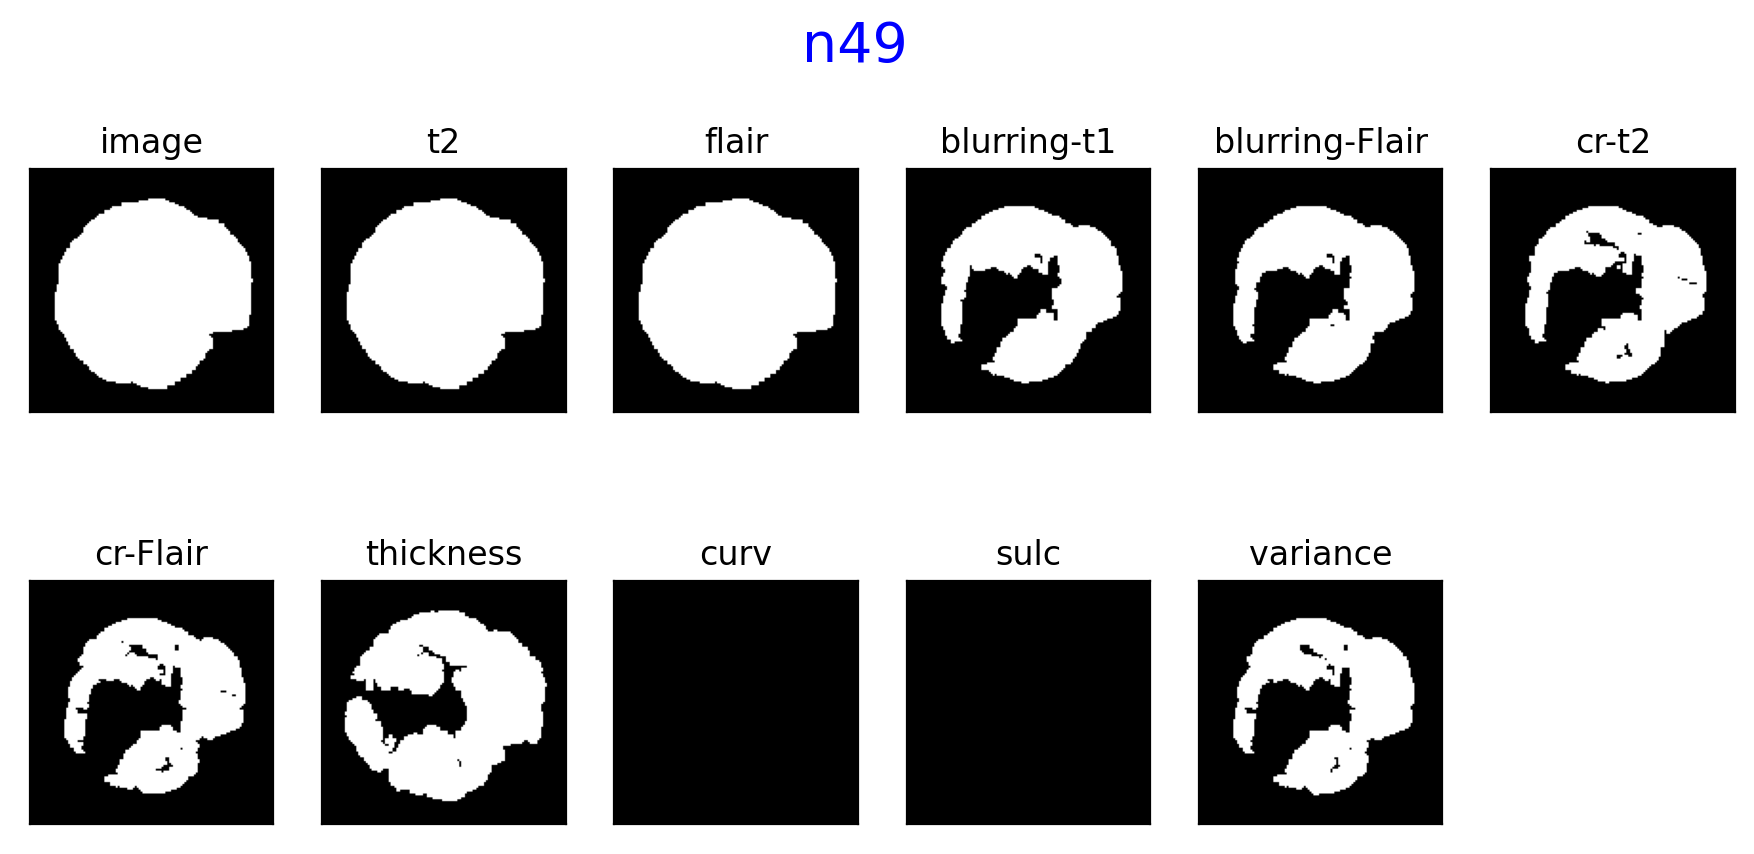

image shape: torch.Size([11, 128, 128, 128])


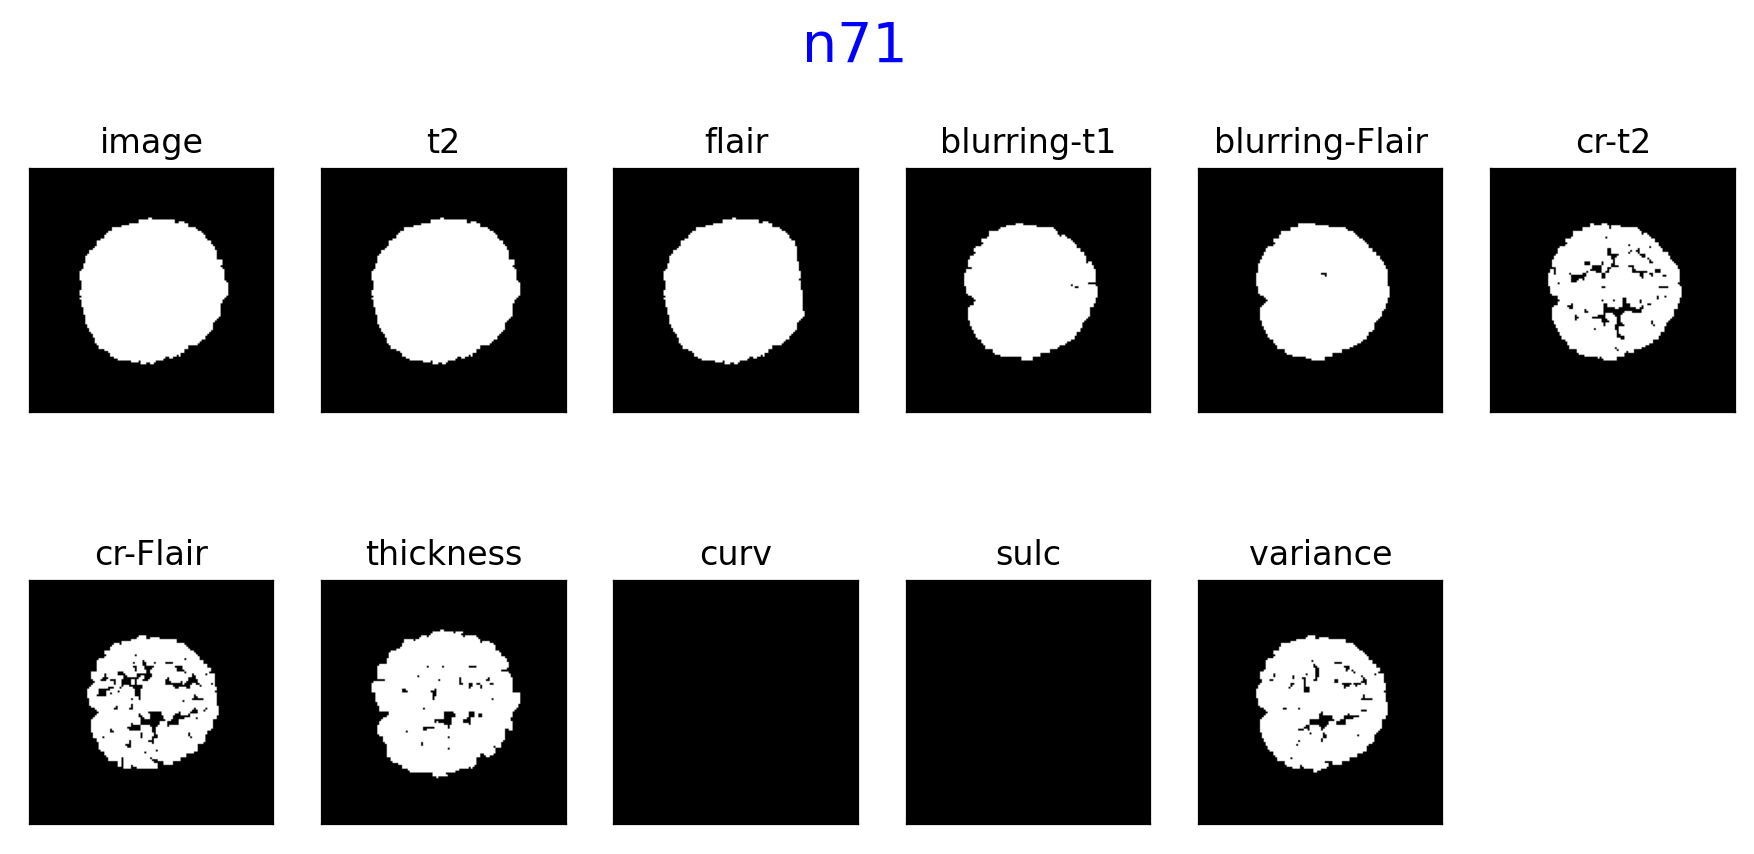

image shape: torch.Size([11, 128, 128, 128])


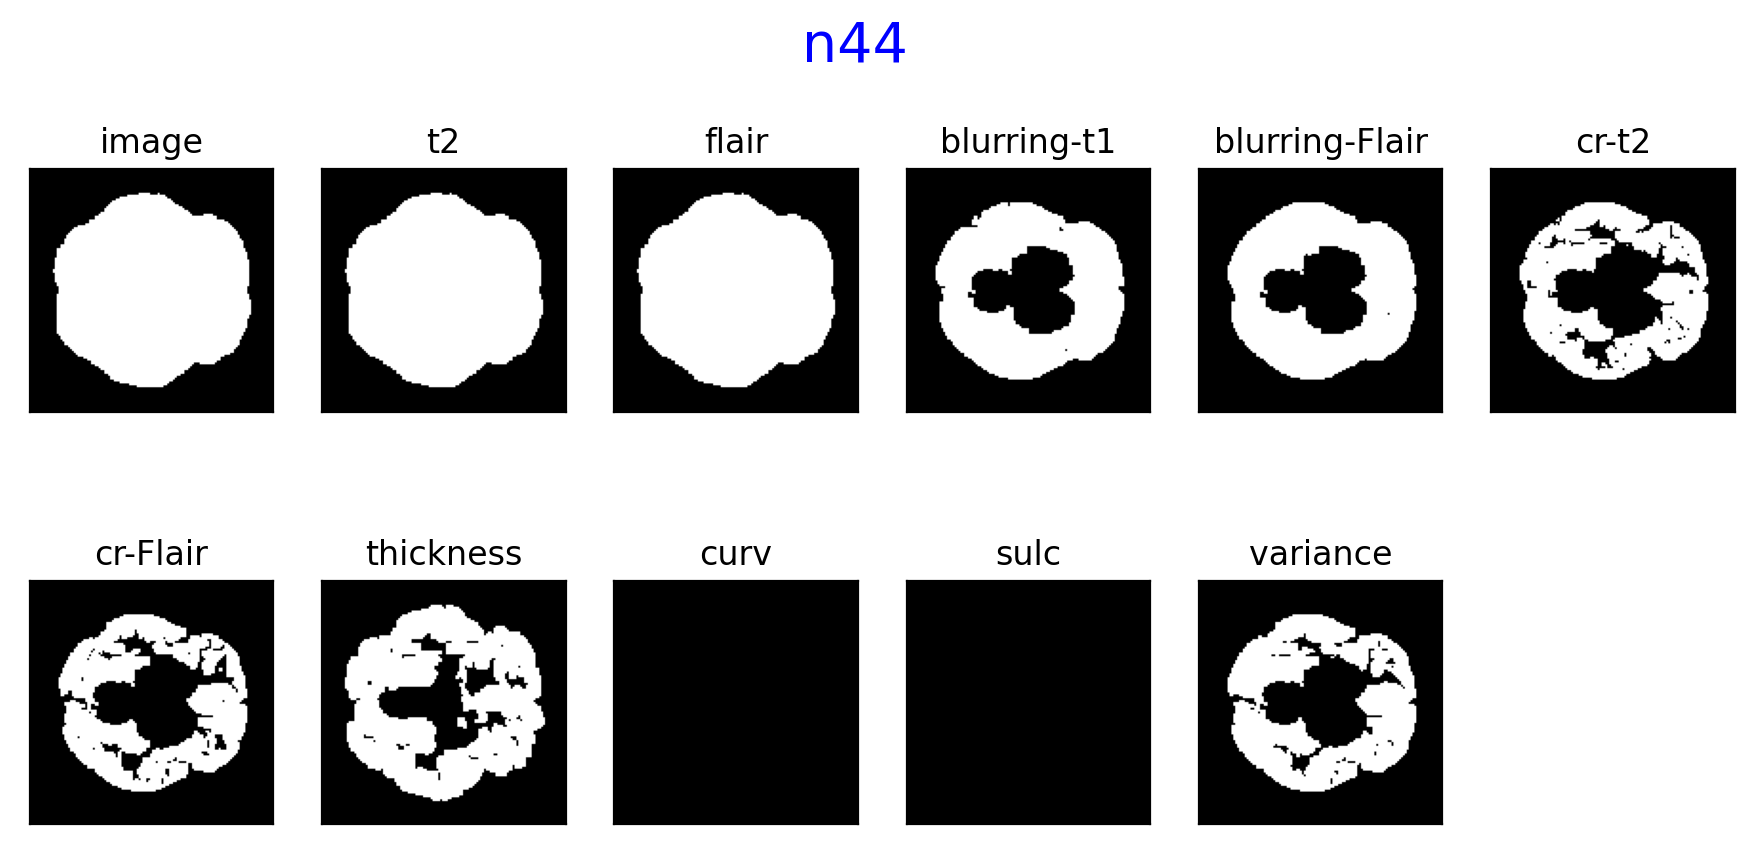

image shape: torch.Size([11, 128, 128, 128])


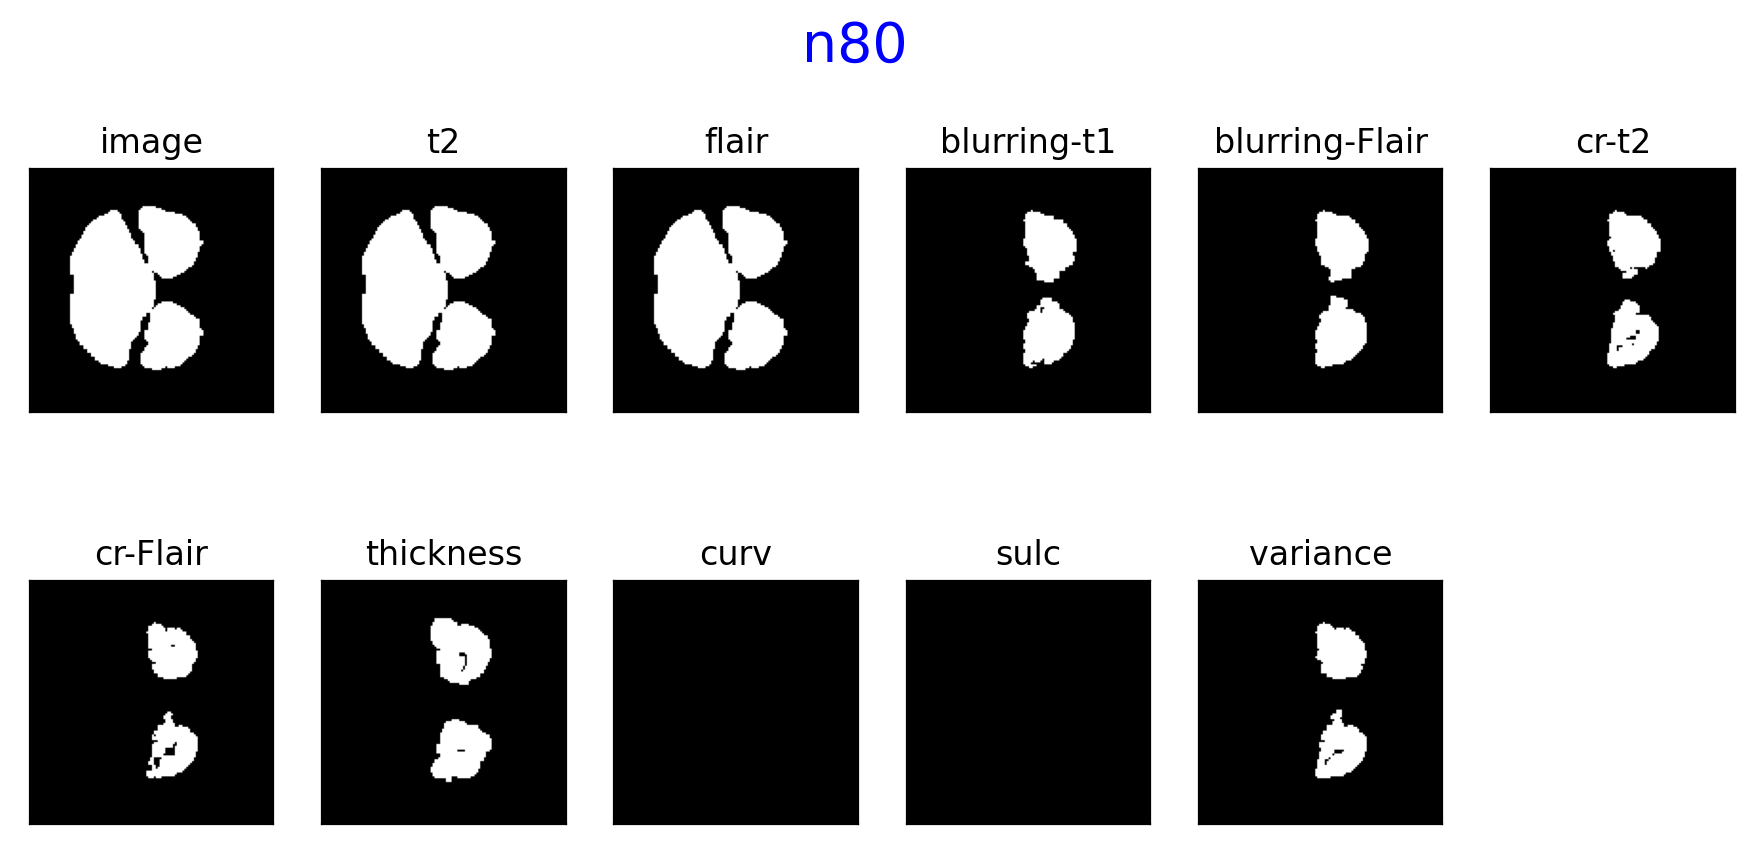

image shape: torch.Size([11, 128, 128, 128])


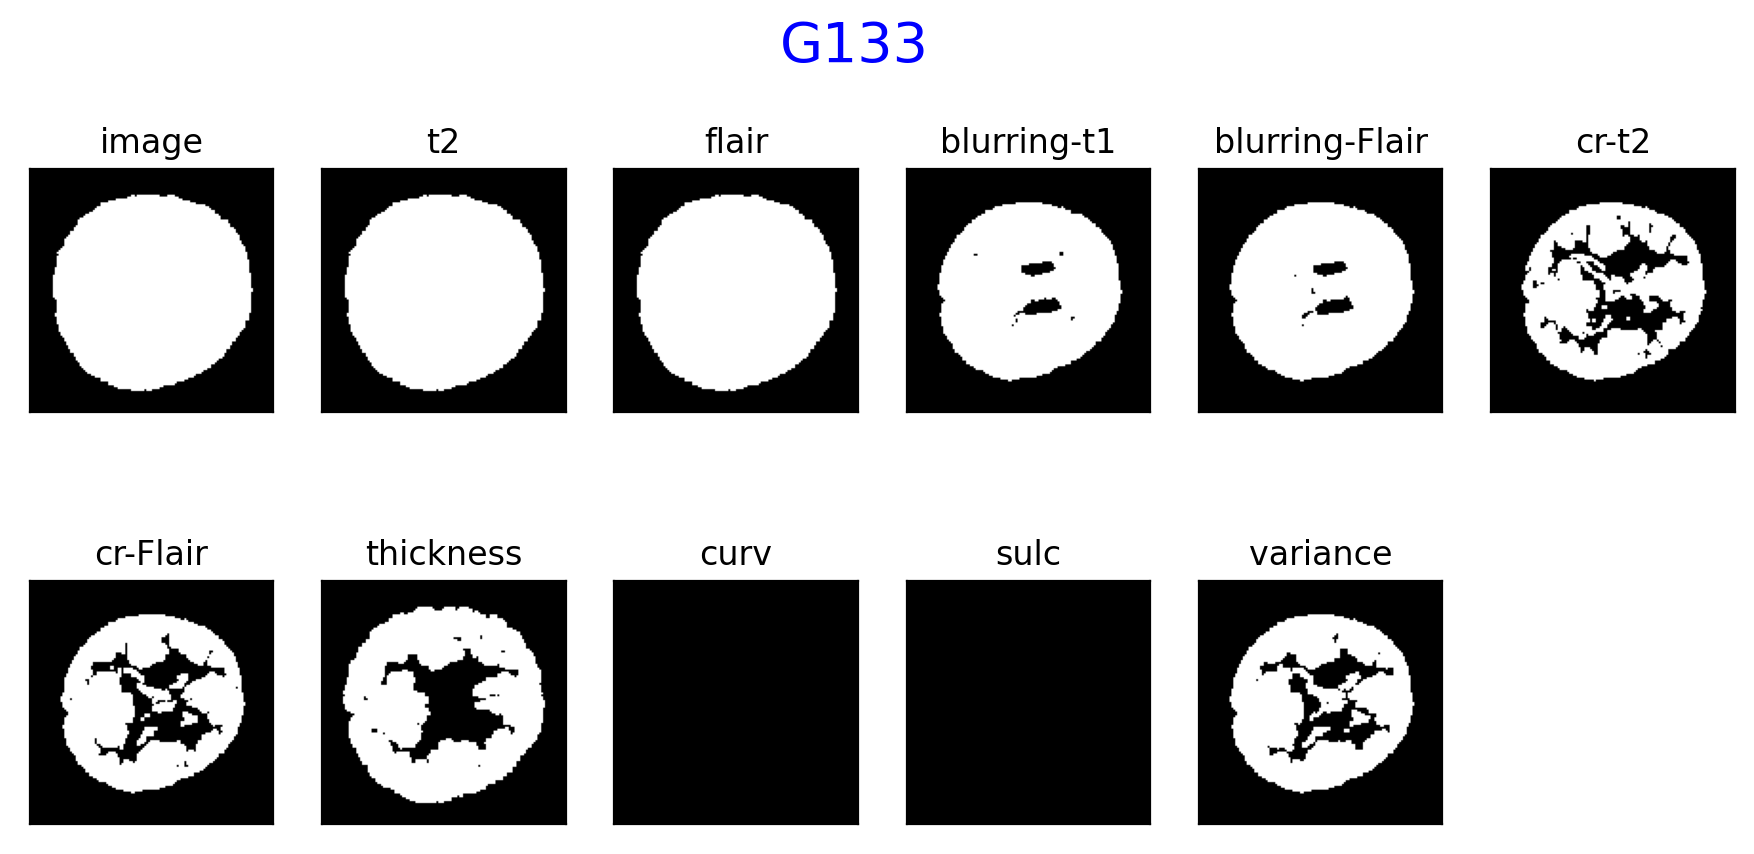

image shape: torch.Size([11, 128, 128, 128])


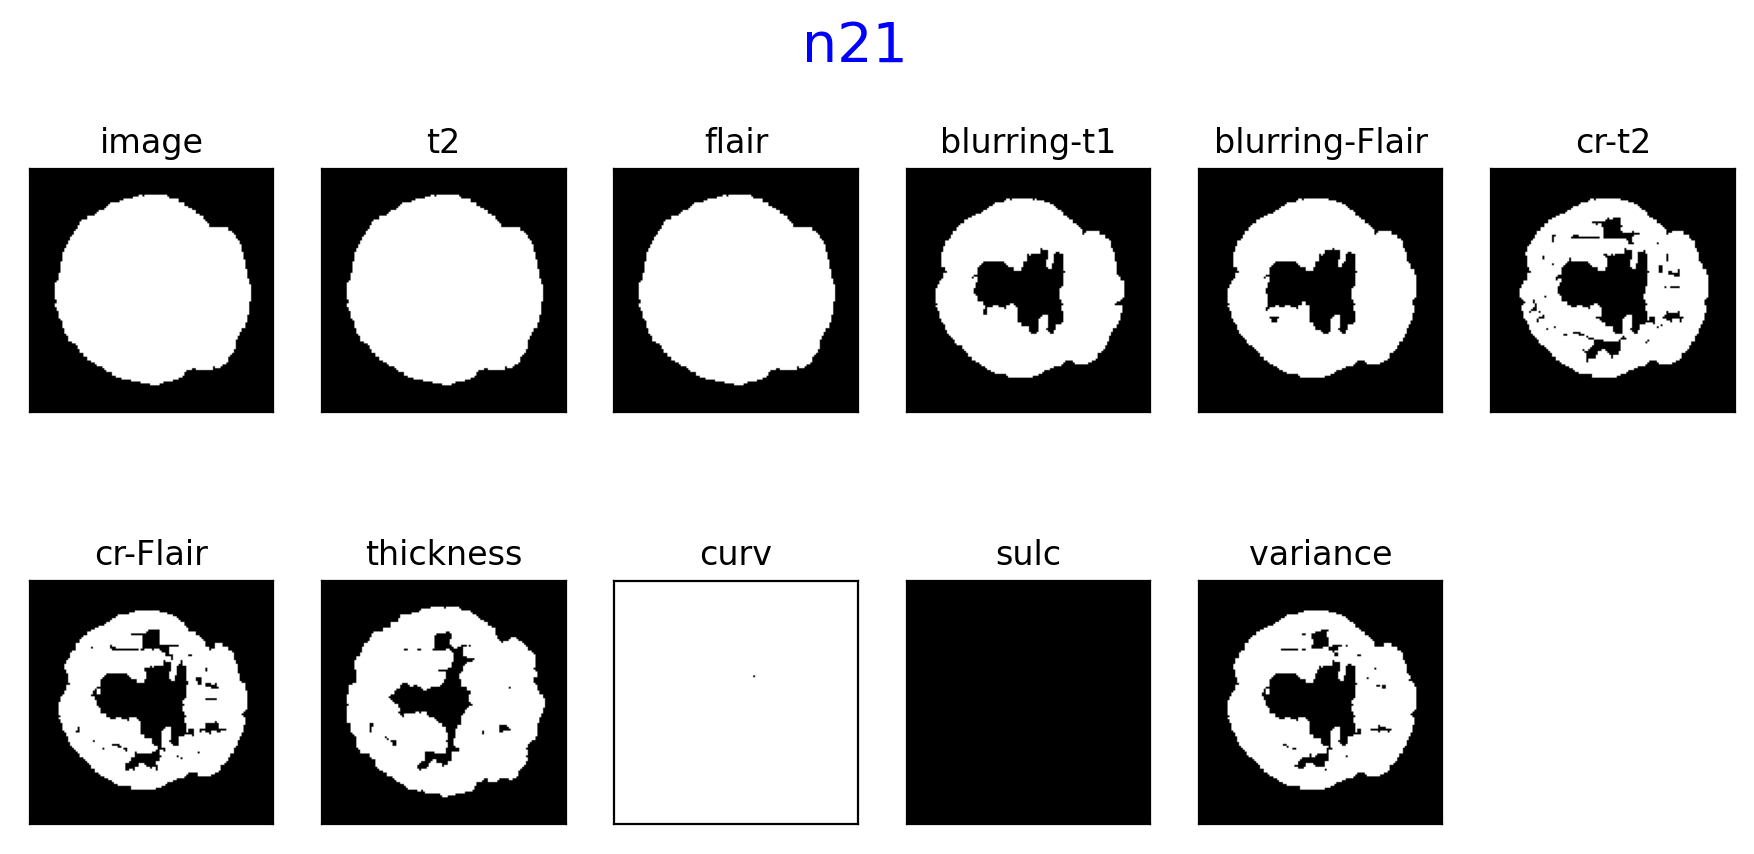

image shape: torch.Size([11, 128, 128, 128])


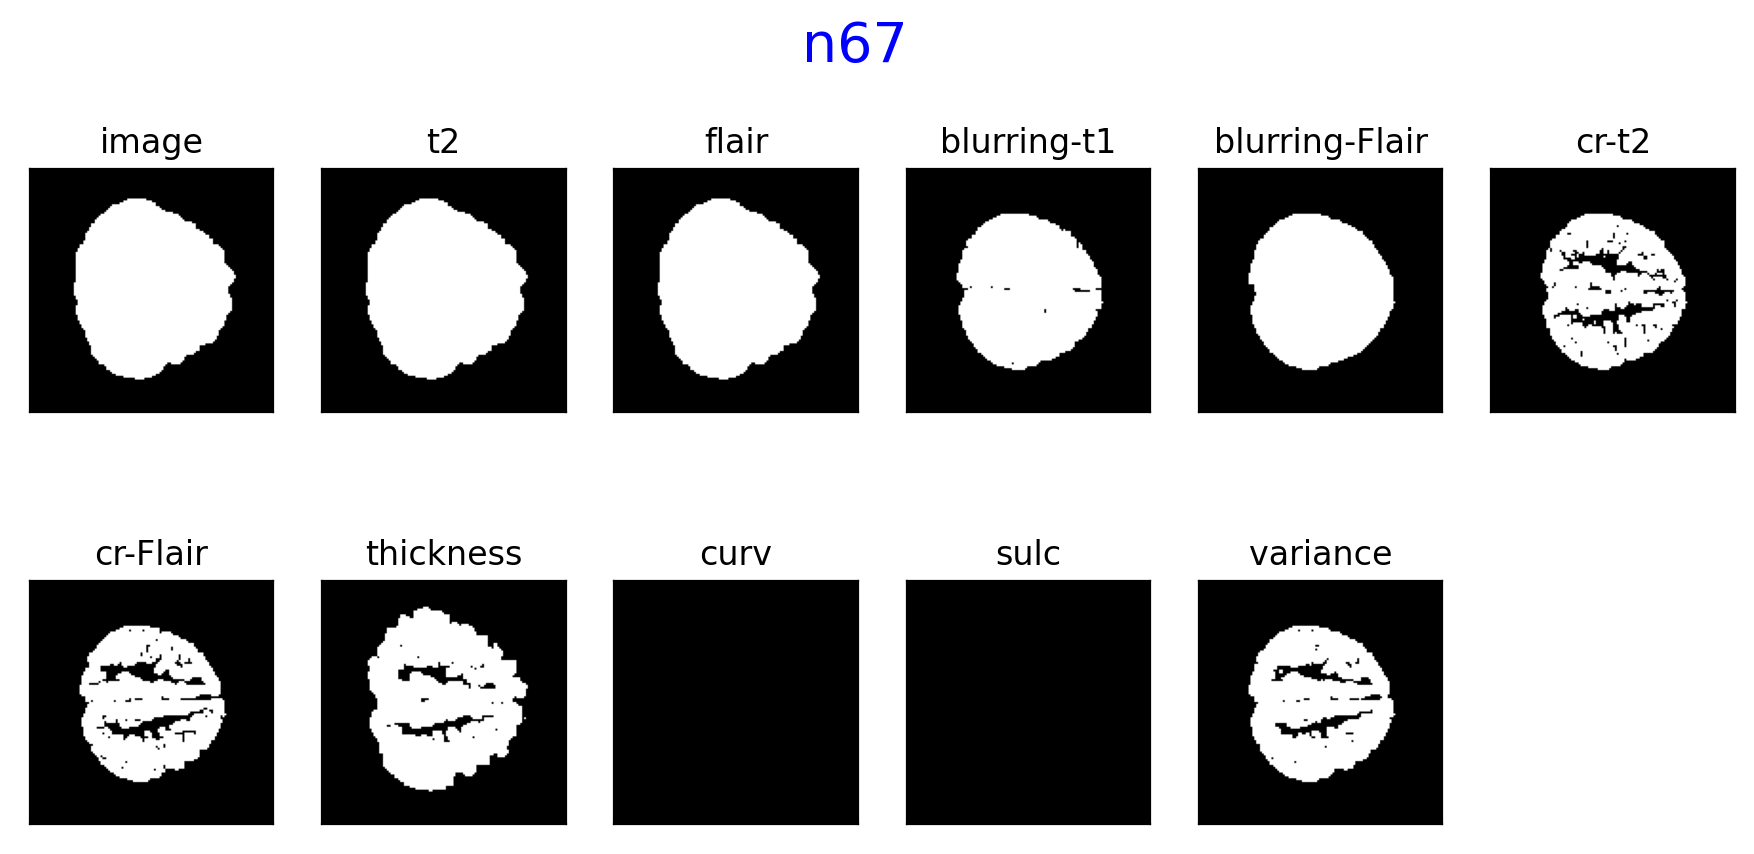

image shape: torch.Size([11, 128, 128, 128])


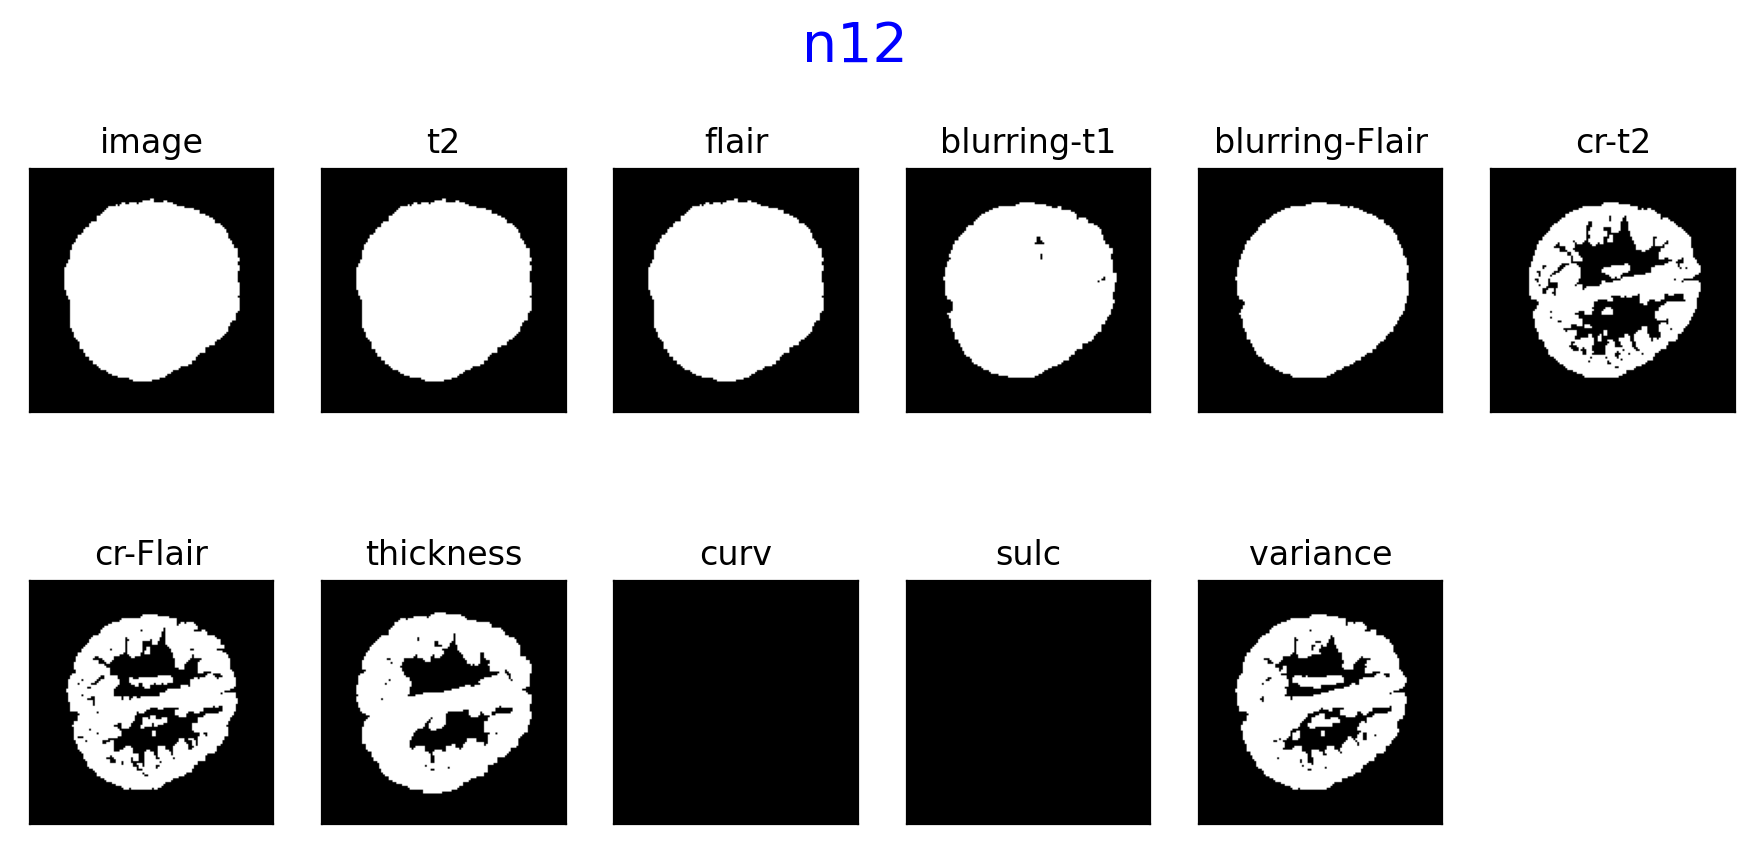

image shape: torch.Size([11, 128, 128, 128])


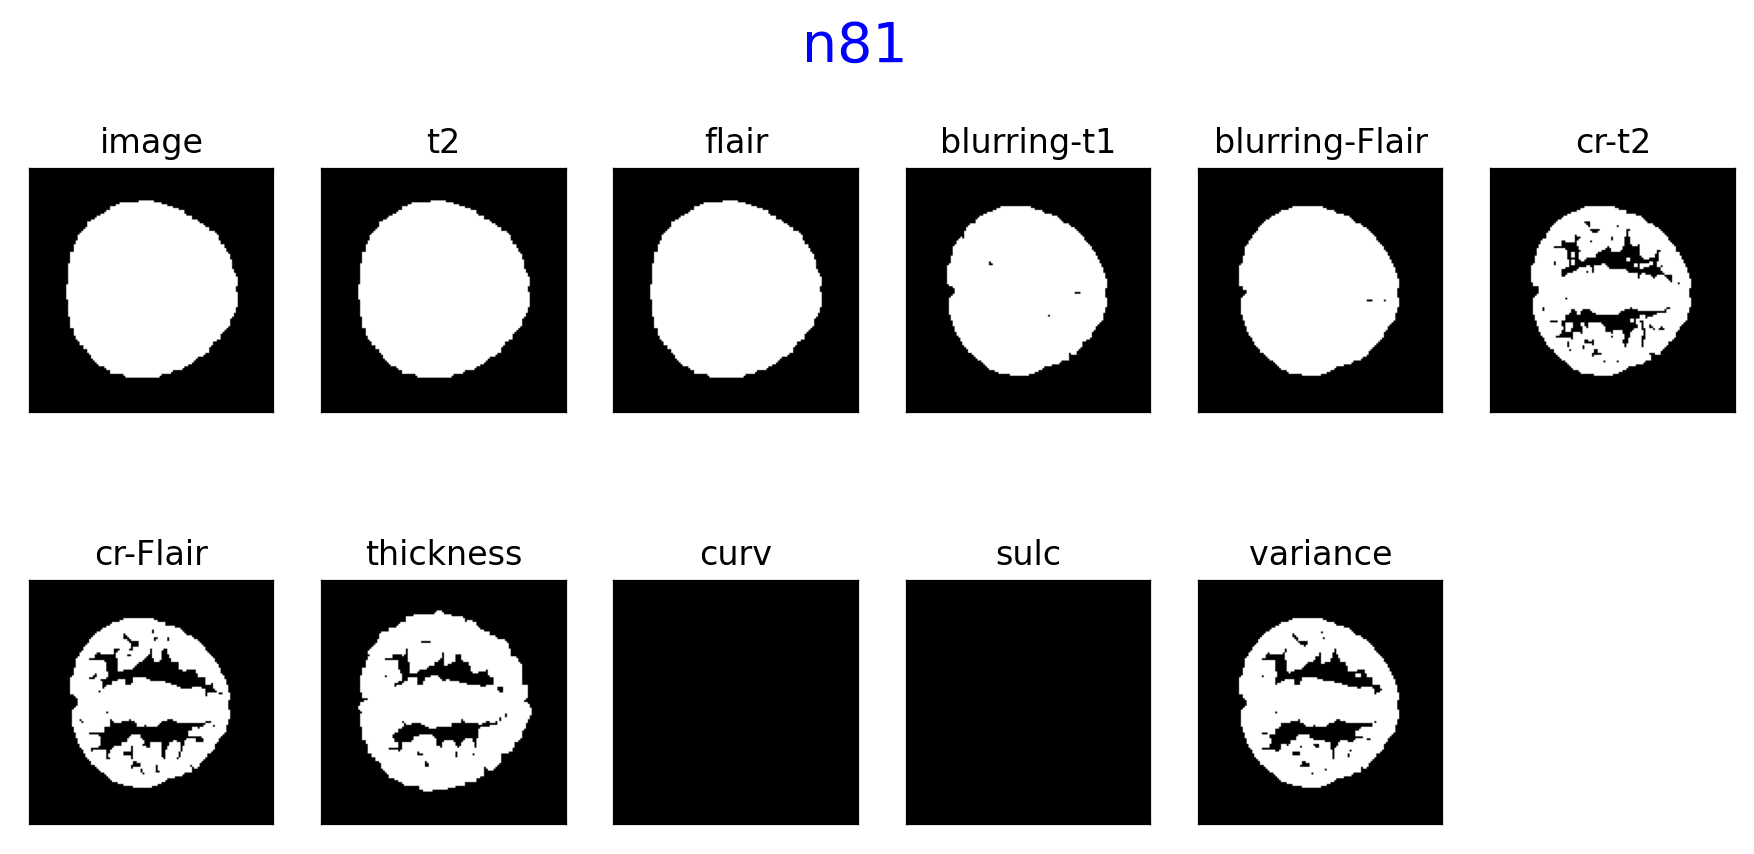

In [69]:
# figures_per_row = 6 # for visualization
# for k in range(check_batch_size):
    
#     image = check_data['image'][k]
#     seg = check_data['seg'][k]
#     label = get_label(check_dataset.data[k]['seg'])
    
#     print(f"image shape: {image.shape}")
    
#     num_of_channels = len(feat_params)
#     # choose z-coord where there is a label maximum over other axes
#     label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    
#     mask = image[:1,...] <= 0 # `background mask
#     torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1

#     fig = plt.figure("image", (len(feat_params), 5), dpi=200)
#     for i in range(num_of_channels):
#         nrows = int(np.ceil(num_of_channels/figures_per_row))
#         cols = num_of_channels%figures_per_row
#         plt.subplot(nrows, figures_per_row, i+1)
#         plt.title(f"{feat_params[i]}")
#         plt.imshow(image[i,:,:,label_pos] > 0, cmap="gray")
#         # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
#         # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
#         plt.xticks([])
#         plt.yticks([])
        
#     fig.suptitle(label, fontsize=20, color='blue')
#     # plt.tight_layout()
#     plt.show()

# Setup dataloaders

In [23]:
# training dataset
train_ds = monai.data.Dataset(data=train_files, transform=train_transf)
train_loader = DataLoader(
    train_ds,
    batch_size=config.opt.train_batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

# validation dataset
val_ds = monai.data.Dataset(data=val_files, transform=val_transf)
val_loader = DataLoader(val_ds, 
                        batch_size=config.opt.val_batch_size, 
                        num_workers=0, 
                        collate_fn=list_data_collate,
                        shuffle=False # important not to shuffle, to ensure label correspondence
                        )

### Before augmentation

In [24]:
# from nilearn.plotting import plot_img
# ind = 0
# plot_img = plot_img(train_files[ind]['seg'],
#          bg_img=train_files[ind]['image'][0],
#          threshold=0.1, alpha=0.5, display_mode='z')
# plot_img
# print(plot_img.cut_coords) # get coordinate of z where lesion center mass

### After augmentation

In [25]:
# plt.figure(figsize=(30,30))
# for i in range(7):
#     plt.subplot(1, 10, i+1)
#     item = train_loader.dataset[ind]
#     image, segme = item["image"], item["seg"]
#     lab_loc = round(np.where(segme>0)[3].shape[0] / 2)
#     lab_pos = np.where(segme>0)[3][lab_loc]
#     plt.imshow(np.rot90(image[0,:, :, lab_pos]), cmap='gray')
#     plt.imshow(np.rot90(segme[0,:, :, lab_pos]), cmap="Reds", alpha=0.4)
#     plt.title("seg overlay")
# plt.show()